# Real-World Data Demonstration

### Team Epsilon-Greedy Quants
#### Michael Lee, Nikat Patel, Jose Antonio Alatorre Sanchez

This notebook demonstrates what a user sees when the user runs the User Guide for Real-World Data Notebook

In [1]:
from environments.e_greedy import DeepTradingEnvironment, LinearAgent

import datetime
import numpy as np
import pandas as pd
import os
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.cla import CLA
import matplotlib.pyplot as plt
from matplotlib import cm
import copy
import quantstats as qs
qs.extend_pandas()
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
from scipy.signal import detrend
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats
import pylab 

In [2]:
root = os.getcwd()
data_env = root+"/data_env/"

# Utility Functions

In [3]:
def _retrieve_asset_dict():
    # obtain close prices from parquet files of ETF price history
    root = os.getcwd()
    data_env = root+"/data_env_MTUM-simulated-USMV/"
    files = [_ for _ in os.listdir(data_env) if "parquet" in _]
    assets_dict = {file: pd.read_parquet(data_env + "/" + file) for file in files}
    counter=0
    for key, value in assets_dict.items():
        if counter==0:
            main_index=value.index
    else:
        main_index=main_index.join(value.index,how="inner")
        
    for key, value in assets_dict.items():
        tmp_df=value.reindex(main_index)
        tmp_df=tmp_df.fillna(method='ffill')
        assets_dict[key]=tmp_df['close']
    return assets_dict

def build_portfolio_df(asset_dict):
    portfolio_df = pd.DataFrame()
    
    for key, value in assets_dict.items():
        key = key.split(".")[0]
        tmp_df = pd.DataFrame(data=value)
        tmp_df.columns=[key]
        portfolio_df = pd.concat([portfolio_df, tmp_df], axis=1)
        
    portfolio_df.index = pd.to_datetime(portfolio_df.index, errors='coerce')
    return portfolio_df

In [4]:
def plot_backtest(linear_agent_train, env_test, test_input, model_run, model):
    ## Create plot of backtest returns
    if not "backtest" in locals():
        backtest=None
    backtest, tmp_weights =linear_agent_train.backtest_policy(epoch=1,backtest=backtest, env_test=env_test, test_input=test_input)
    plt.figure(figsize=(8,4))
    plt.plot(backtest,color="blue")
    plt.gcf().autofmt_xdate()
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel("Date", fontsize = 10)
    plt.ylabel("Backtest", fontsize = 10)
    plt.title("Backtest on Test Data: "+ model,fontsize = 16)
    plt.savefig(root+'/temp_persisted_data/test_backtest_plot_'+model_run+model+'.png')
    tmp_weights.to_csv(root+'/temp_persisted_data/test_backtest_weights_'+model_run+model+'.csv')
    plt.show()
    return backtest

# Reviewing Real-World Data

In [5]:
# read a sample ETF

data_env_two_asset = root+ "/data_env_MTUM-simulated-USMV/"

pd.read_parquet(data_env_two_asset+'MTUM.parquet').head()



,open,high,low,close,volume
index,,,,,
2017-01-03 05:00:00+00:00,72.59413,72.90881,72.21272,72.54646,297832
2017-01-04 05:00:00+00:00,72.69902,73.09952,72.69902,72.97556,225891
2017-01-05 05:00:00+00:00,72.98509,73.25208,72.84206,73.21394,412561
2017-01-06 05:00:00+00:00,73.20441,73.77654,73.04230,73.63351,260918
2017-01-09 05:00:00+00:00,73.66212,73.76701,73.50001,73.60490,165800


In [6]:
USMV_ETF = pd.read_parquet(data_env+'USMV.parquet').copy()
test_ETF = pd.DataFrame(columns=USMV_ETF.columns, index=USMV_ETF.index) 
test_ETF_close = np.random.normal(1,0.01,len(USMV_ETF.index))
print(np.mean(test_ETF_close))
test_ETF["close"]=  test_ETF_close
# test_ETF["close"]=  USMV_ETF["close"]
print(test_ETF)
test_ETF.to_parquet("data_env_MTUM-simulated-USMV/simulated_asset.parquet")

1.0003053600201834
                          open high  low     close volume
index                                                    
2017-01-03 05:00:00+00:00  NaN  NaN  NaN  0.992556    NaN
2017-01-04 05:00:00+00:00  NaN  NaN  NaN  1.003648    NaN
2017-01-05 05:00:00+00:00  NaN  NaN  NaN  1.006913    NaN
2017-01-06 05:00:00+00:00  NaN  NaN  NaN  1.010051    NaN
2017-01-09 05:00:00+00:00  NaN  NaN  NaN  0.994226    NaN
...                        ...  ...  ...       ...    ...
2020-11-17 05:00:00+00:00  NaN  NaN  NaN  0.996811    NaN
2020-11-18 05:00:00+00:00  NaN  NaN  NaN  0.989796    NaN
2020-11-19 05:00:00+00:00  NaN  NaN  NaN  1.010360    NaN
2020-11-20 05:00:00+00:00  NaN  NaN  NaN  0.983964    NaN
2020-11-23 05:00:00+00:00  NaN  NaN  NaN  1.003456    NaN

[981 rows x 5 columns]


In [7]:
train_input_returns = test_ETF["close"]
train_input_returns = train_input_returns.to_returns().dropna()
np.std(train_input_returns)

0.014837131350028189

In [8]:
0.01/np.sqrt(252)

0.000629940788348712

In [9]:
# create a portfolio
assets_dict = _retrieve_asset_dict()
portfolio_df = build_portfolio_df(assets_dict)
portfolio_df=portfolio_df.rename(columns = {'USMV':'Simulated Asset'})

In [10]:
# create a train dataset and de-mean the time series

portfolio_df_train = portfolio_df[portfolio_df.index >= '2019-02-01']
portfolio_df_train = portfolio_df_train[portfolio_df_train.index <= '2020-02-01']
portfolio_df_train.sub(portfolio_df_train.mean())

portfolio_df_train.head()

,MTUM,simulated_asset
index,,
2019-02-01 05:00:00+00:00,104.3037,1.008114
2019-02-04 05:00:00+00:00,104.4988,1.019218
2019-02-05 05:00:00+00:00,104.6647,1.002947
2019-02-06 05:00:00+00:00,104.7428,0.997053
2019-02-07 05:00:00+00:00,104.2744,1.007484


In [11]:
portfolio_df_train["MTUM"].index

DatetimeIndex(['2019-02-01 05:00:00+00:00', '2019-02-04 05:00:00+00:00',
               '2019-02-05 05:00:00+00:00', '2019-02-06 05:00:00+00:00',
               '2019-02-07 05:00:00+00:00', '2019-02-08 05:00:00+00:00',
               '2019-02-11 05:00:00+00:00', '2019-02-12 05:00:00+00:00',
               '2019-02-13 05:00:00+00:00', '2019-02-14 05:00:00+00:00',
               ...
               '2020-01-17 05:00:00+00:00', '2020-01-21 05:00:00+00:00',
               '2020-01-22 05:00:00+00:00', '2020-01-23 05:00:00+00:00',
               '2020-01-24 05:00:00+00:00', '2020-01-27 05:00:00+00:00',
               '2020-01-28 05:00:00+00:00', '2020-01-29 05:00:00+00:00',
               '2020-01-30 05:00:00+00:00', '2020-01-31 05:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='index', length=252, freq=None)

In [12]:
X = portfolio_df_train.index.to_julian_date() - portfolio_df_train.index.to_julian_date()[0] 
y = portfolio_df_train["MTUM"].values

print(X)
X = sm.add_constant(X)
model = sm.OLS(endog=y, exog=X)
results = model.fit()
# Show the summary
results.summary()

Float64Index([  0.0,   3.0,   4.0,   5.0,   6.0,   7.0,  10.0,  11.0,  12.0,
               13.0,
              ...
              350.0, 354.0, 355.0, 356.0, 357.0, 360.0, 361.0, 362.0, 363.0,
              364.0],
             dtype='float64', name='index', length=252)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     1440.
Date:                Mon, 28 Dec 2020   Prob (F-statistic):          9.78e-106
Time:                        02:36:57   Log-Likelihood:                -579.22
No. Observations:                 252   AIC:                             1162.
Df Residuals:                     250   BIC:                             1169.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        106.3141      0.305    348.591      0.000     105.713     106.915
x1             0.0551      0.001     37.949      0.000       0.052       0.058
==============================================================================
Omnibus:                        9.379   Durbin-Watson:                   0.132
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.858
Skew:                           0.471   Prob(JB):                      0.00723
Kurtosis:                       2.776   Cond. No.                         420.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
portfolio_df_train.iloc[0]

MTUM               104.303700
simulated_asset      1.008114
Name: 2019-02-01 05:00:00+00:00, dtype: float64

In [14]:
holtwinters = ExponentialSmoothing(portfolio_df_train["MTUM"], seasonal=None)

fit = holtwinters.fit(optimized=True, smoothing_level=0.1, smoothing_slope=0.1)

fit.__dict__
HW_predict = fit.predict(start=portfolio_df_train.iloc[0].name, end = portfolio_df_train.iloc[-1].name)
print(HW_predict)



index
2019-02-01 05:00:00+00:00    105.732124
2019-02-04 05:00:00+00:00    105.589282
2019-02-05 05:00:00+00:00    105.480234
2019-02-06 05:00:00+00:00    105.398680
2019-02-07 05:00:00+00:00    105.333092
                                ...    
2020-01-27 05:00:00+00:00    127.884037
2020-01-28 05:00:00+00:00    128.065704
2020-01-29 05:00:00+00:00    128.343183
2020-01-30 05:00:00+00:00    128.552275
2020-01-31 05:00:00+00:00    128.832637
Length: 252, dtype: float64


C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
portfolio_df_train.iloc[-1].name

Timestamp('2020-01-31 05:00:00+0000', tz='UTC')

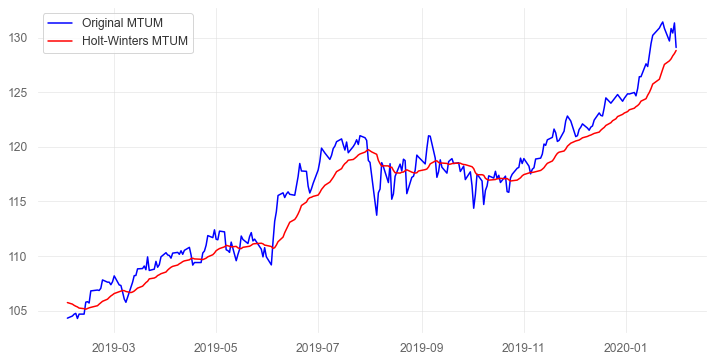

In [16]:
plt.figure(figsize=(12,6))

plt.plot(portfolio_df_train["MTUM"], color = "blue", label = "Original MTUM")
plt.plot(HW_predict, color ="red", label = "Holt-Winters MTUM")
plt.legend(loc="upper left")
plt.show()
plt.close()

Float64Index([  0.0,   3.0,   4.0,   5.0,   6.0,   7.0,  10.0,  11.0,  12.0,
               13.0,
              ...
              350.0, 354.0, 355.0, 356.0, 357.0, 360.0, 361.0, 362.0, 363.0,
              364.0],
             dtype='float64', name='index', length=252)
y [105.73212432 105.58928189 105.4802337  105.39868033 105.3330923
 105.22722307 105.17195076 105.12220568 105.18671511 105.2496536
 105.29360824 105.44439742 105.58791768 105.71318591 105.84641732
 106.04242559 106.19834303 106.33866873 106.44154185 106.56144767
 106.7230329  106.78551961 106.83687765 106.82358988 106.7472309
 106.64825781 106.69773203 106.78616882 106.92723194 107.05613875
 107.23265487 107.39443938 107.56346545 107.6814889  107.90529001
 107.98227101 108.06331391 108.20778252 108.28391427 108.37594284
 108.53029856 108.7074387  108.84628483 108.96634635 109.04990171
 109.17116154 109.28715539 109.37390985 109.48432886 109.55136598
 109.64794938 109.76231444 109.795673   109.7326157  109.69937413
 109

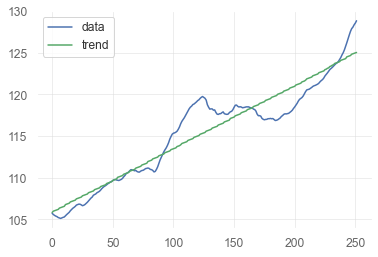

r2: 0.903262582918518
rmse 1.8098686654141471


In [17]:
X = HW_predict.index.to_julian_date() - HW_predict.index.to_julian_date()[0] 
print(X)
X = np.reshape(X, (len(X), 1))
y = HW_predict.values
print("y", y)
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)
plt.plot(y)
plt.plot(trend)
plt.legend(['data', 'trend'])
plt.show()

r2 = r2_score(y, trend)
rmse = np.sqrt(mean_squared_error(y, trend))
print('r2:', r2)
print('rmse', rmse)

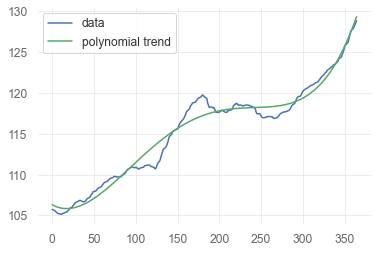

In [18]:
pf = PolynomialFeatures(degree=4)
Xp = pf.fit_transform(X)

md2 = LinearRegression()
md2.fit(Xp, y)
trendp = md2.predict(Xp)

plt.plot(X, y)
plt.plot(X, trendp)
plt.legend(['data', 'polynomial trend'])
plt.show()

In [19]:
md2.coef_

array([ 0.00000000e+00, -5.76158032e-02,  1.89407941e-03, -9.39997539e-06,
        1.40341351e-08])

In [20]:
r2 = r2_score(y, trendp)
rmse = np.sqrt(mean_squared_error(y, trendp))
print('r2:', r2)
print('rmse', rmse)

r2: 0.96994979958762
rmse 1.0087266708108857


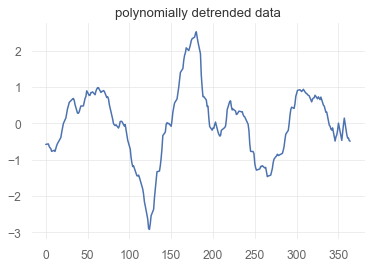

In [21]:
detrpoly = [y[i] - trendp[i] for i in range(0, len(y))]
plt.plot(X, detrpoly)
plt.title('polynomially detrended data')
plt.show()

In [22]:
sm.stats.acorr_ljungbox(detrpoly, return_df=True)

C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\statsmodels\stats\diagnostic.py:533: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  "lags to silence this warning.", FutureWarning)


,lb_stat,lb_pvalue
1,249.032467,4.220581e-56
2,487.743420,1.224227e-106
3,712.130266,4.917065e-154
4,919.757058,8.727282e-198
5,1108.533746,1.897023e-237
6,1276.919983,1.073857e-272
7,1425.215228,1.350577e-303
8,1553.535432,0.000000e+00
9,1662.627666,0.000000e+00
10,1753.227866,0.000000e+00


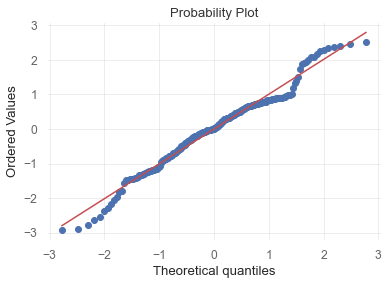

In [23]:
stats.probplot(detrpoly, dist="norm", plot=pylab)
pylab.show()

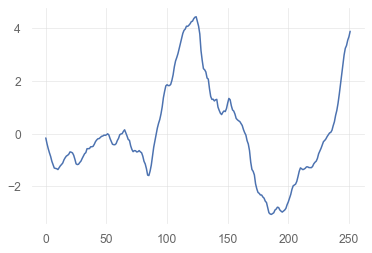

In [24]:
detrend_MTUM = detrend(HW_predict, axis=- 1, type='linear', bp=0, overwrite_data=False).reshape(-1, 1)
plt.plot(detrend_MTUM)


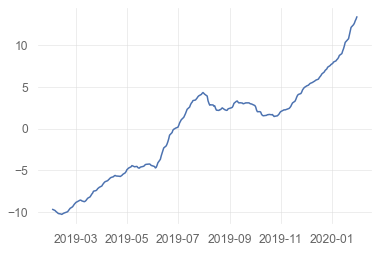

In [25]:
demean_MTUM = HW_predict - np.mean(HW_predict)
plt.plot(demean_MTUM)

In [26]:
demean_MTUM

index
2019-02-01 05:00:00+00:00    -9.689065
2019-02-04 05:00:00+00:00    -9.831908
2019-02-05 05:00:00+00:00    -9.940956
2019-02-06 05:00:00+00:00   -10.022509
2019-02-07 05:00:00+00:00   -10.088097
                               ...    
2020-01-27 05:00:00+00:00    12.462848
2020-01-28 05:00:00+00:00    12.644514
2020-01-29 05:00:00+00:00    12.921994
2020-01-30 05:00:00+00:00    13.131085
2020-01-31 05:00:00+00:00    13.411448
Length: 252, dtype: float64

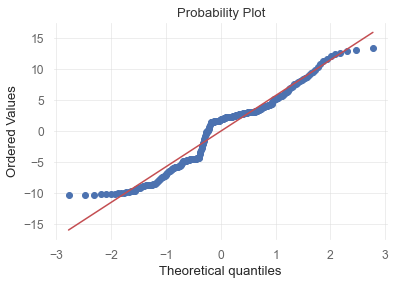

In [27]:
stats.probplot(demean_MTUM, dist="norm", plot=pylab)
pylab.show()

In [28]:
demean_returns = np.diff(demean_MTUM)

In [29]:
sm.stats.acorr_ljungbox(demean_returns, return_df=True)

C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\statsmodels\stats\diagnostic.py:533: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  "lags to silence this warning.", FutureWarning)


,lb_stat,lb_pvalue
1,169.824632,8.081066e-39
2,282.701669,4.093668e-62
3,361.724972,4.312661e-78
4,416.887156,6.239810e-89
5,456.504253,1.941771e-96
6,487.300279,4.572536e-102
7,514.952447,4.886347e-107
8,536.734738,9.171371e-111
9,556.631449,4.214351e-114
10,572.456754,1.397414e-116


In [30]:
# create a test dataset consisting of 6 months of data and de-mean the time series

portfolio_df_test = portfolio_df[portfolio_df.index >= '2020-04-16']
portfolio_df_test = portfolio_df_test[portfolio_df_test.index <= '2020-11-16']
portfolio_df_test.sub(portfolio_df_test.mean())

portfolio_df_test.head()

,MTUM,simulated_asset
index,,
2020-04-16 04:00:00+00:00,116.0638,0.992574
2020-04-17 04:00:00+00:00,117.9653,0.989323
2020-04-20 04:00:00+00:00,116.7009,0.996499
2020-04-21 04:00:00+00:00,112.3304,0.989938
2020-04-22 04:00:00+00:00,115.3270,1.005994


In [31]:
test_input_returns = portfolio_df_test.to_returns().dropna()
test_input_returns = test_input_returns.loc[(test_input_returns != 0).any(1)]


# Set Up Environment

In [32]:
# parameters related to the transformation of data, this parameters govern an step before the algorithm
out_reward_window=datetime.timedelta(days=7)

meta_parameters = {"in_bars_count": 14,
                   "out_reward_window":out_reward_window ,
                   "state_type":"in_window_out_window",
                   "risk_aversion":1,
                   "include_previous_weights":False}

# parameters that are related to the objective/reward function construction
objective_parameters = {"percent_commission": .001}

print("===Meta Parameters===")
print(meta_parameters)
print("===Objective Parameters===")
print(objective_parameters)

detrend=True

# create an environment and build features based on Real-World Dataset located in the "data_env" folder 
env = DeepTradingEnvironment.build_environment_from_dirs_and_transform(meta_parameters, objective_parameters,data_hash="MTUM-simulated-USMV", data_dir="data_env_MTUM-simulated-USMV", detrend=detrend)

number_of_assets = env.number_of_assets

===Meta Parameters===
{'in_bars_count': 14, 'out_reward_window': datetime.timedelta(days=7), 'state_type': 'in_window_out_window', 'risk_aversion': 1, 'include_previous_weights': False}
===Objective Parameters===
{'percent_commission': 0.001}


C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\micha\OneDrive\Documents\CSCI E-599a Data Science Capstone\capstone\utils.py:380: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit = holtwinters.fit(optimized=True, remove_bias=True, smoothing_level=0.1, smoothing_slope=0.1)


trend_coef [ 80.07282613  80.11388031  80.15493449  80.19598866  80.31915119
  80.36020536  80.40125954  80.44231371  80.48336789  80.64758459
  80.68863877  80.72969294  80.77074712  80.89390964  80.93496382
  80.976018    81.01707217  81.05812635  81.18128887  81.22234305
  81.26339722  81.3044514   81.34550558  81.4686681   81.50972228
  81.55077645  81.59183063  81.6328848   81.75604733  81.79710151
  81.83815568  81.87920986  81.92026403  82.08448073  82.12553491
  82.16658909  82.20764326  82.33080579  82.37185996  82.41291414
  82.45396831  82.49502249  82.61818502  82.65923919  82.70029337
  82.74134754  82.78240172  82.90385365  82.94490783  82.985962
  83.02701618  83.06807036  83.19123288  83.23228706  83.27334123
  83.31439541  83.35544958  83.47861211  83.51966629  83.56072046
  83.60177464  83.64282881  83.76599134  83.80704552  83.84809969
  83.88915387  83.93020804  84.05337057  84.09442474  84.13547892
  84.17653309  84.3407498   84.38180397  84.42285815  84.46391232
 

C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\micha\OneDrive\Documents\CSCI E-599a Data Science Capstone\capstone\utils.py:380: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit = holtwinters.fit(optimized=True, remove_bias=True, smoothing_level=0.1, smoothing_slope=0.1)


trend_coef [1.00115244 1.00115125 1.00115005 1.00114886 1.00114528 1.00114409
 1.0011429  1.00114171 1.00114051 1.00113574 1.00113455 1.00113336
 1.00113217 1.00112859 1.0011274  1.0011262  1.00112501 1.00112382
 1.00112024 1.00111905 1.00111786 1.00111666 1.00111547 1.00111189
 1.0011107  1.00110951 1.00110832 1.00110712 1.00110355 1.00110235
 1.00110116 1.00109997 1.00109878 1.00109401 1.00109281 1.00109162
 1.00109043 1.00108685 1.00108566 1.00108447 1.00108327 1.00108208
 1.0010785  1.00107731 1.00107612 1.00107493 1.00107373 1.0010702
 1.00106901 1.00106782 1.00106663 1.00106543 1.00106186 1.00106066
 1.00105947 1.00105828 1.00105709 1.00105351 1.00105232 1.00105112
 1.00104993 1.00104874 1.00104516 1.00104397 1.00104278 1.00104158
 1.00104039 1.00103681 1.00103562 1.00103443 1.00103324 1.00102847
 1.00102727 1.00102608 1.00102489 1.0010237  1.00102012 1.00101893
 1.00101773 1.00101654 1.00101535 1.00101177 1.00101058 1.00100939
 1.00100819 1.001007   1.00100342 1.00100223 1.00100

#### Split Features and Forward Returns into Training and Test sets

In [33]:
features = pd.read_parquet("temp_persisted_data/only_features_MTUM-simulated-USMV")
features

,MTUM.parquet_log_returns,simulated_asset.parquet_log_returns,MTUM.parquet_log_returns_lag_0,simulated_asset.parquet_log_returns_lag_0,MTUM.parquet_log_returns_lag_1,simulated_asset.parquet_log_returns_lag_1,MTUM.parquet_log_returns_lag_2,simulated_asset.parquet_log_returns_lag_2,MTUM.parquet_log_returns_lag_3,simulated_asset.parquet_log_returns_lag_3,...,simulated_asset.parquet_log_returns_lag_12,MTUM.parquet_log_returns_lag_13,simulated_asset.parquet_log_returns_lag_13,MTUM.parquet_trend_coef,MTUM.parquet_demeaned_return,simulated_asset.parquet_trend_coef,simulated_asset.parquet_demeaned_return,MTUM.parquet_rolling_volatility,simulated_asset.parquet_rolling_volatility,bias
index,,,,,,,,,,,,,,,,,,,,,
2018-01-24 05:00:00+00:00,-0.002235,-0.011705,0.001251,-0.006662,0.006099,-0.003869,0.005865,-0.011117,-0.001085,0.020026,...,-0.008455,0.009956,0.001132,0.271831,0.851756,0.728169,0.319079,0.028653,0.000069,1
2018-01-25 05:00:00+00:00,0.002235,0.044680,-0.002235,-0.011705,0.001251,-0.006662,0.006099,-0.003869,0.005865,-0.011117,...,0.013380,0.008348,-0.008455,0.272535,0.831194,0.727465,0.177551,0.028490,0.000998,1
2018-01-26 05:00:00+00:00,0.014011,-0.044937,0.002235,0.044680,-0.002235,-0.011705,0.001251,-0.006662,0.006099,-0.003869,...,0.008626,0.007997,0.013380,0.273239,0.827650,0.726761,0.809966,1.168300,0.000999,1
2018-01-29 05:00:00+00:00,-0.007602,0.019062,0.014011,-0.044937,0.002235,0.044680,-0.002235,-0.011705,0.001251,-0.006662,...,-0.000296,0.002807,0.008626,0.275352,0.838784,0.724648,0.167805,0.342303,0.000182,1
2018-01-30 05:00:00+00:00,-0.015470,0.007274,-0.007602,0.019062,0.014011,-0.044937,0.002235,0.044680,-0.002235,-0.011705,...,-0.014437,0.003731,-0.000296,0.276056,0.824195,0.723944,0.451162,1.425009,0.000033,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-10 05:00:00+00:00,-0.012501,0.011129,-0.029419,-0.005269,-0.000195,0.000971,0.018257,-0.007845,0.043942,0.014772,...,0.008589,-0.005482,-0.012124,0.990845,0.756847,0.009155,0.347685,2.099014,0.000061,1
2020-11-11 05:00:00+00:00,0.020153,0.017714,-0.012501,0.011129,-0.029419,-0.005269,-0.000195,0.000971,0.018257,-0.007845,...,0.002164,-0.000939,0.008589,0.991549,0.695544,0.008451,0.508249,4.453672,0.000166,1
2020-11-12 05:00:00+00:00,-0.002721,-0.032942,0.020153,0.017714,-0.012501,0.011129,-0.029419,-0.005269,-0.000195,0.000971,...,-0.026322,0.002614,0.002164,0.992254,0.791481,0.007746,0.744545,0.150502,0.000538,1


In [34]:
features = pd.read_parquet("temp_persisted_data/only_features_MTUM-simulated-USMV")

features_train = features[features.index >= '2019-02-01']
features_train = features_train[features_train.index <= '2020-02-01']

features_test = features[features.index >= '2020-04-16']
features_test = features_test[features_test.index <= '2020-11-16']


features_train.head()

,MTUM.parquet_log_returns,simulated_asset.parquet_log_returns,MTUM.parquet_log_returns_lag_0,simulated_asset.parquet_log_returns_lag_0,MTUM.parquet_log_returns_lag_1,simulated_asset.parquet_log_returns_lag_1,MTUM.parquet_log_returns_lag_2,simulated_asset.parquet_log_returns_lag_2,MTUM.parquet_log_returns_lag_3,simulated_asset.parquet_log_returns_lag_3,...,simulated_asset.parquet_log_returns_lag_12,MTUM.parquet_log_returns_lag_13,simulated_asset.parquet_log_returns_lag_13,MTUM.parquet_trend_coef,MTUM.parquet_demeaned_return,simulated_asset.parquet_trend_coef,simulated_asset.parquet_demeaned_return,MTUM.parquet_rolling_volatility,simulated_asset.parquet_rolling_volatility,bias
index,,,,,,,,,,,,,,,,,,,,,
2019-02-01 05:00:00+00:00,0.001872,0.009588,0.009133,-0.013624,0.020738,0.012551,-0.004144,0.010226,-0.010047,-0.004917,...,0.004788,0.000679,-0.002758,0.534507,0.817613,0.465493,0.433730,0.033736,0.000046,1
2019-02-04 05:00:00+00:00,0.001869,0.010954,0.001872,0.009588,0.009133,-0.013624,0.020738,0.012551,-0.004144,0.010226,...,0.012978,-0.008770,0.004788,0.536620,0.788523,0.463380,0.566164,0.020546,0.000065,1
2019-02-05 05:00:00+00:00,0.001586,-0.016094,0.001869,0.010954,0.001872,0.009588,0.009133,-0.013624,0.020738,0.012551,...,-0.032079,0.015635,0.012978,0.537324,0.810749,0.462676,0.704719,0.014836,0.000130,1
2019-02-06 05:00:00+00:00,0.000746,-0.005894,0.001586,-0.016094,0.001869,0.010954,0.001872,0.009588,0.009133,-0.013624,...,0.035076,-0.001543,-0.032079,0.538028,0.806916,0.461972,0.461342,0.003616,0.000022,1
2019-02-07 05:00:00+00:00,-0.004482,0.010407,0.000746,-0.005894,0.001586,-0.016094,0.001869,0.010954,0.001872,0.009588,...,-0.008332,0.007595,0.035076,0.538732,0.800743,0.461268,0.381944,0.108966,0.000054,1


In [35]:
forward_return_dates = pd.read_parquet("temp_persisted_data/forward_return_dates_MTUM-simulated-USMV")

forward_return_dates_train = forward_return_dates[forward_return_dates.index >= '2019-02-01']
forward_return_dates_train = forward_return_dates_train[forward_return_dates_train.index <= '2020-02-01']

forward_return_dates_test = forward_return_dates[forward_return_dates.index > '2020-04-16']
forward_return_dates_test = forward_return_dates_test[forward_return_dates_test.index <= '2020-11-16']

forward_return_dates_train.head()

,"forward_return_7_days,_0:00:00"
index,
2019-02-01 05:00:00+00:00,2019-02-08 05:00:00+00:00
2019-02-04 05:00:00+00:00,2019-02-11 05:00:00+00:00
2019-02-05 05:00:00+00:00,2019-02-12 05:00:00+00:00
2019-02-06 05:00:00+00:00,2019-02-13 05:00:00+00:00
2019-02-07 05:00:00+00:00,2019-02-14 05:00:00+00:00


In [36]:
forward_returns = pd.read_parquet("temp_persisted_data/only_forward_returns_MTUM-simulated-USMV")

forward_returns_train = forward_returns[forward_returns.index >= '2019-02-01']
forward_returns_train = forward_returns_train[forward_returns_train.index <= '2020-02-01']
forward_returns_train.sub(forward_returns_train.mean())

forward_returns_test = forward_returns[forward_returns.index >= '2020-04-16']
forward_returns_test = forward_returns_test[forward_returns_test.index <= '2020-11-16']
forward_returns_test.sub(forward_returns_test.mean())

forward_returns_train.head()

,"MTUM.parquet_forward_return_7_days,_0:00:00","simulated_asset.parquet_forward_return_7_days,_0:00:00"
index,,
2019-02-01 05:00:00+00:00,0.003555,0.003894
2019-02-04 05:00:00+00:00,0.001681,-0.017498
2019-02-05 05:00:00+00:00,0.010535,0.007621
2019-02-06 05:00:00+00:00,0.010247,-0.002082
2019-02-07 05:00:00+00:00,0.013568,0.004676


# Run Policy-Gradient Method Algorithms on Real-World Data

In [37]:
max_iter = 4001
model_run = "MTUM-simulated_reward_variance_risk_1_detrend_"
sample_observations = 32
plot_interval = 500

### REINFORCE

pre-sampling indices: 100%|████████████████████████████████████████████████████████████| 96/96 [00:01<00:00, 50.69it/s]


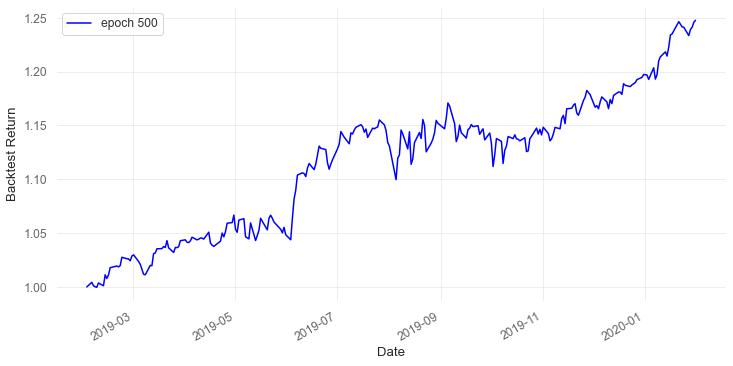

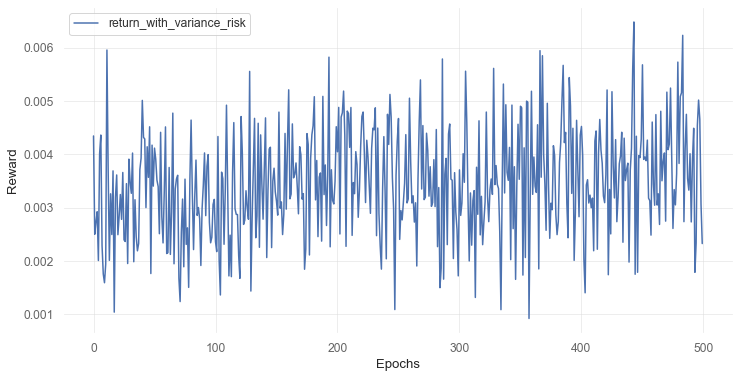

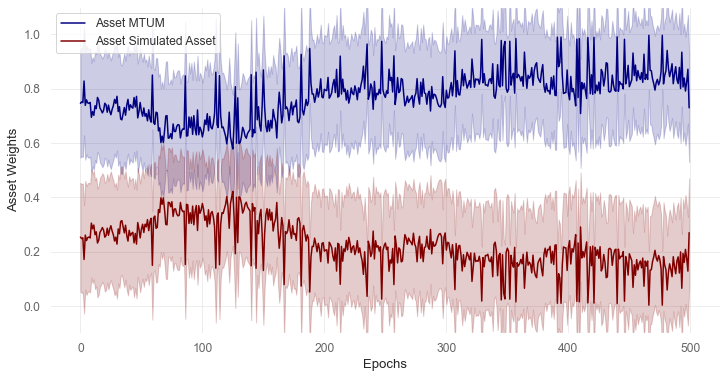

[[-2.11473883e-02  4.87058403e-02  1.20037642e-02 ...  5.20109631e-01
   2.06306079e-04  5.66937965e+00]
 [ 2.99491518e-03  6.05231832e-02  5.24901739e-02 ... -6.45123403e-02
  -3.48943096e-04 -6.81568117e+00]
 [-2.07967099e-03  4.67863003e-03 -3.91167761e-03 ... -5.02101319e-02
  -1.79656571e-05 -5.99145971e-01]
 ...
 [ 5.09837805e-03  8.53653958e-03 -9.47600746e-03 ... -5.79965365e-02
  -1.60833408e-05 -2.73000476e+00]
 [-1.39202006e-02  1.88685217e-02  7.59789507e-03 ... -2.44333253e-01
  -3.69265096e-05 -4.74837759e+00]
 [ 2.46316238e-03  7.78422474e-03  5.86548023e-02 ... -1.28113458e-01
  -2.57154309e-05 -3.96877564e+00]]


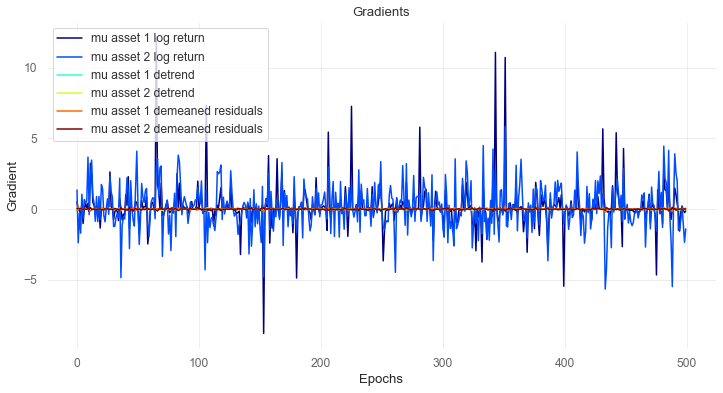

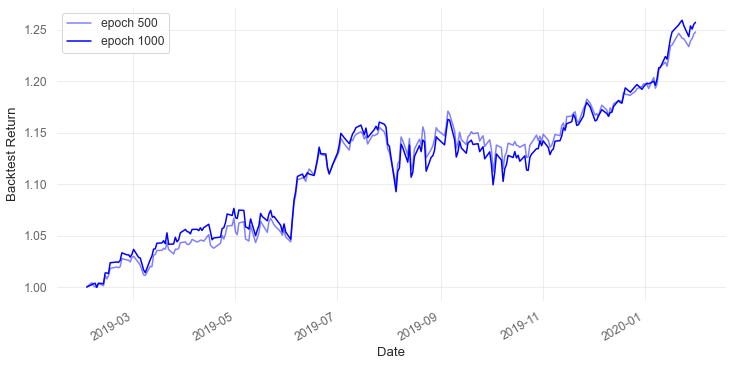

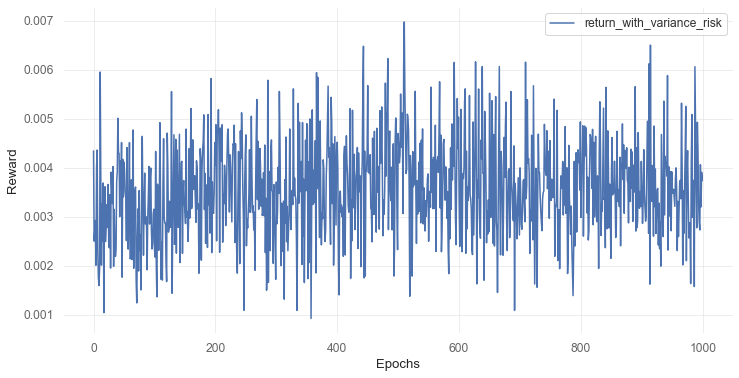

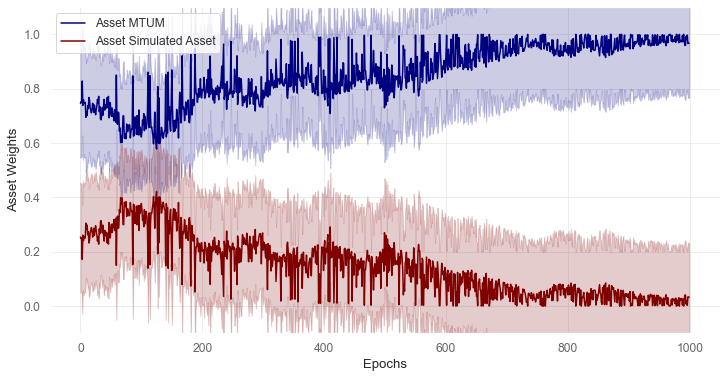

[[-2.11473883e-02  4.87058403e-02  1.20037642e-02 ...  5.20109631e-01
   2.06306079e-04  5.66937965e+00]
 [ 2.99491518e-03  6.05231832e-02  5.24901739e-02 ... -6.45123403e-02
  -3.48943096e-04 -6.81568117e+00]
 [-2.07967099e-03  4.67863003e-03 -3.91167761e-03 ... -5.02101319e-02
  -1.79656571e-05 -5.99145971e-01]
 ...
 [-1.86777663e-03 -3.77452382e-02 -3.27354579e-02 ...  4.02330731e-02
   2.17618103e-04  4.25059450e+00]
 [-2.25458301e-02 -5.50277071e-03 -3.97961708e-02 ... -5.17440452e-01
  -4.18835584e-05 -6.96354876e+00]
 [-8.03658519e-03 -4.67565409e-04  4.27896705e-03 ... -2.00405229e-01
  -3.55608662e-06 -1.91984772e+00]]


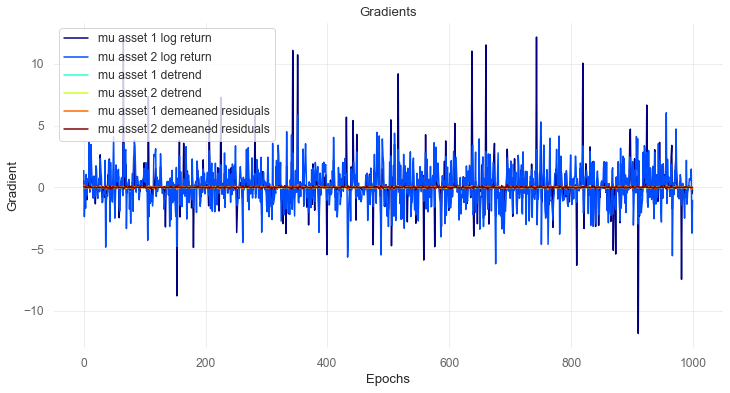

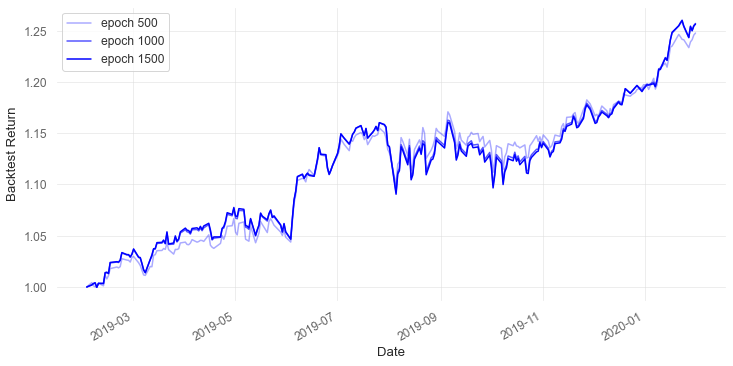

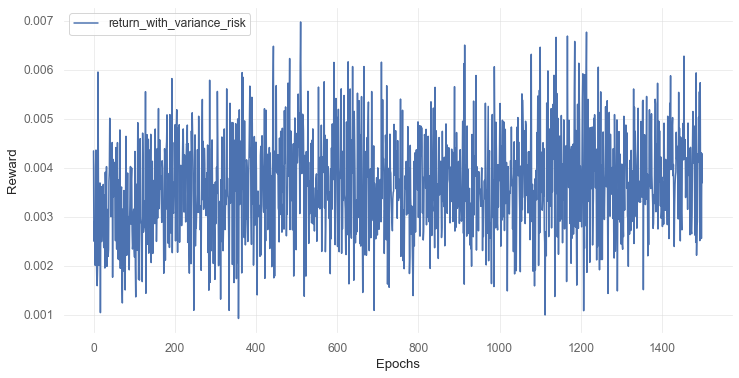

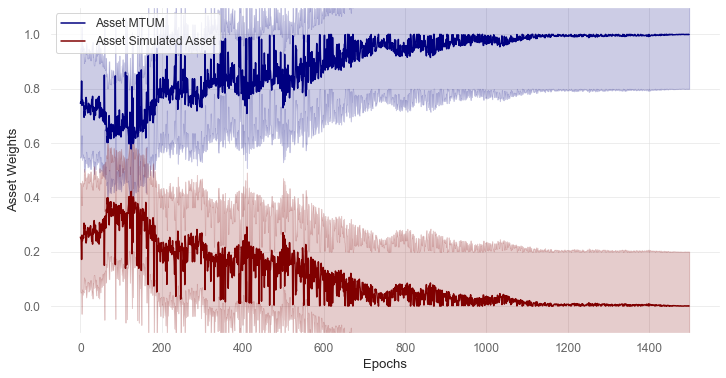

[[-2.11473883e-02  4.87058403e-02  1.20037642e-02 ...  5.20109631e-01
   2.06306079e-04  5.66937965e+00]
 [ 2.99491518e-03  6.05231832e-02  5.24901739e-02 ... -6.45123403e-02
  -3.48943096e-04 -6.81568117e+00]
 [-2.07967099e-03  4.67863003e-03 -3.91167761e-03 ... -5.02101319e-02
  -1.79656571e-05 -5.99145971e-01]
 ...
 [ 0.00000000e+00  3.01236772e-04  5.58239778e-04 ... -1.41936640e-04
  -1.56322271e-07 -2.93434196e-01]
 [-8.23039524e-03 -2.00879620e-03 -1.45276627e-02 ... -1.88892554e-01
  -1.52896672e-05 -2.54205582e+00]
 [ 3.30354300e-02 -1.41016539e-03  3.03502255e-02 ... -1.19288587e+00
  -2.93764356e-07 -5.45708755e+00]]


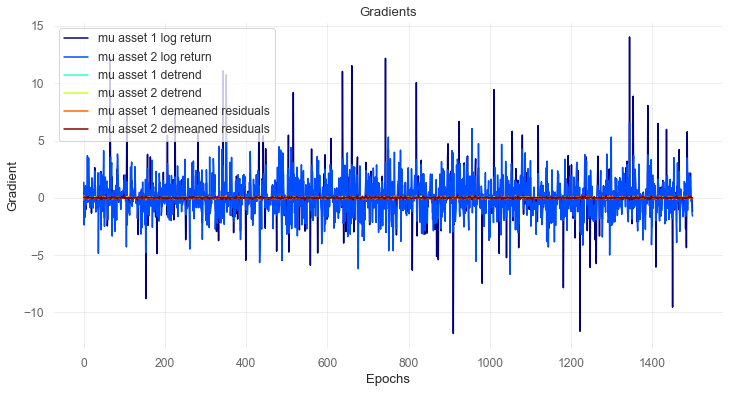

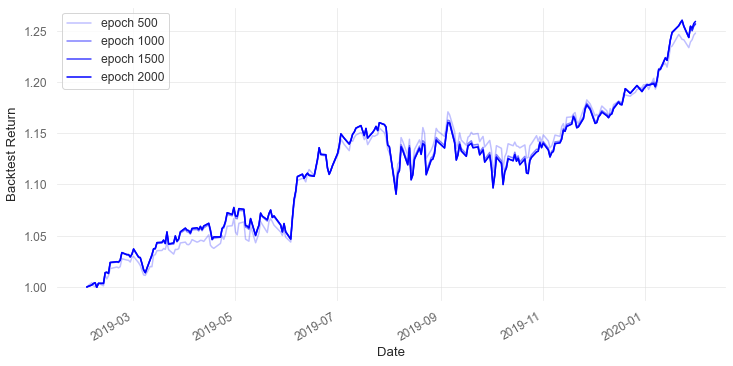

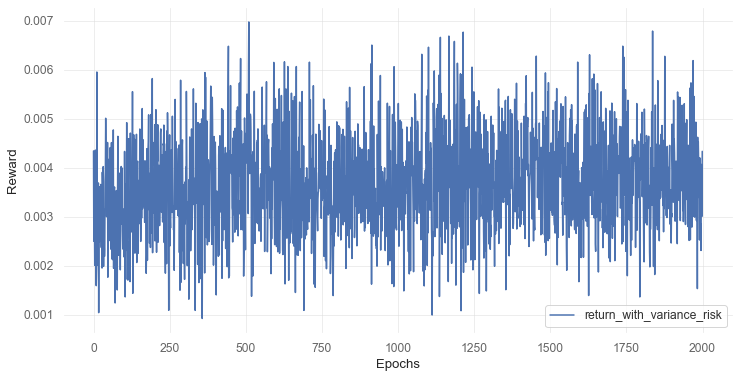

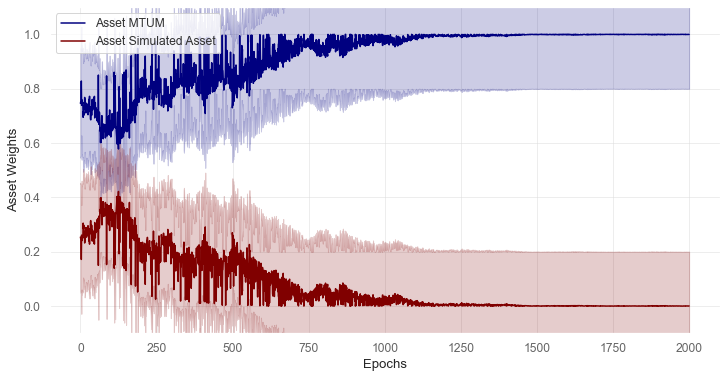

[[-2.11473883e-02  4.87058403e-02  1.20037642e-02 ...  5.20109631e-01
   2.06306079e-04  5.66937965e+00]
 [ 2.99491518e-03  6.05231832e-02  5.24901739e-02 ... -6.45123403e-02
  -3.48943096e-04 -6.81568117e+00]
 [-2.07967099e-03  4.67863003e-03 -3.91167761e-03 ... -5.02101319e-02
  -1.79656571e-05 -5.99145971e-01]
 ...
 [-8.43514414e-03 -5.31694958e-02 -1.11755326e-02 ... -1.39124412e-01
  -4.06379011e-04 -3.40155005e+00]
 [-7.58015490e-03 -8.64653126e-03  1.97679536e-03 ... -3.01301632e-01
  -3.46623577e-05 -1.18731284e+00]
 [ 1.66202180e-02  7.10399189e-02  2.01784551e-02 ...  4.64380598e-01
   6.26225222e-04  3.90043555e+00]]


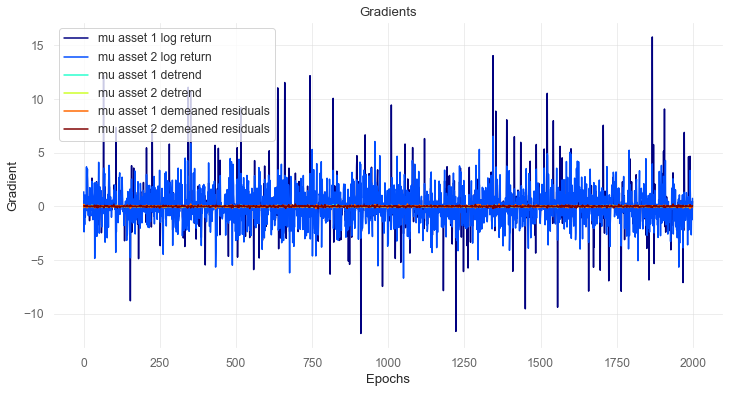

KeyboardInterrupt: 

In [38]:
# create environment and run REINFORCE

env_reinforce_train=DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_reinforce_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_reinforce = LinearAgent(environment=env_reinforce_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_reinforce.REINFORCE_fit(max_iterations=max_iter, add_baseline=False, plot_every = plot_interval, train_input = portfolio_df_train, model_run = model_run, detrend=detrend, verbose=True)

In [ ]:
# perform backtest 
backtest_reinforce = plot_backtest(linear_agent_reinforce, env_reinforce_test, portfolio_df_test, model_run, model="REINFORCE")
backtest_reinforce.to_csv('temp_persisted_data/'+model_run+'backtest_reinforce.csv')

In [ ]:
(test_input_returns+1).cumprod().plot()

In [ ]:
(test_input_returns.sum(axis=1)+1).cumprod().plot()

### REINFORCE with Baseline

In [ ]:
# create environment and run REINFORCE with baseline
env_reinforce_baseline_train = DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_reinforce_baseline_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_reinforce_baseline = LinearAgent(environment=env_reinforce_baseline_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_reinforce_baseline.REINFORCE_fit(max_iterations=max_iter, add_baseline=True, plot_every = plot_interval, train_input = portfolio_df_train, model_run = model_run, detrend=detrend, verbose=True)

In [ ]:
# perform backtest 
backtest_reinforce_baseline = plot_backtest(linear_agent_reinforce_baseline, env_reinforce_baseline_test, portfolio_df_test, model_run, model="REINFORCE with Baseline")
backtest_reinforce_baseline.to_csv('temp_persisted_data/'+model_run+'backtest_reinforce_baseline.csv')

### Actor-Critic

In [ ]:
# create environment and run Actor-Critic 

env_actor_critic_no_trace_train = DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_actor_critic_no_trace_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_actor_critic_no_trace = LinearAgent(environment=env_actor_critic_no_trace_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_actor_critic_no_trace.ACTOR_CRITIC_FIT(use_traces=False,max_iterations=max_iter, plot_every = plot_interval,train_input = portfolio_df_train, model_run = model_run, detrend=detrend, verbose=True)

In [ ]:
# perform backtest
backtest_actor_critic_no_trace = plot_backtest(linear_agent_actor_critic_no_trace, env_actor_critic_no_trace_test,  portfolio_df_test, model_run, model="Actor-Critic without Eligibility Traces")
backtest_actor_critic_no_trace.to_csv('temp_persisted_data/'+model_run+'backtest_actor_critic_no_trace.csv')

### Actor-Critic with Eligibility Traces

In [ ]:
# create environment and run Actor-Critic with Eligibility Traces 
env_actor_critic_trace_train = DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_actor_critic_trace_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_actor_critic_trace = LinearAgent(environment=env_actor_critic_trace_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_actor_critic_trace.ACTOR_CRITIC_FIT(use_traces=True,max_iterations=max_iter, plot_every = plot_interval,train_input = portfolio_df_train, model_run = model_run, detrend=detrend, verbose=True)

In [ ]:
# perform backtest 
backtest_actor_critic_trace = plot_backtest(linear_agent_actor_critic_trace, env_actor_critic_trace_test,  portfolio_df_test, model_run, model="Actor-Critic with Eligibility Traces")
backtest_actor_critic_trace.to_csv('temp_persisted_data/'+model_run+'backtest_actor_critic_trace.csv')